Coletando dados históricos...


[*********************100%%**********************]  1 of 1 completed


Tratando dados...
Analisando dados...
             Open        High         Low       Close   Adj Close  \
count  201.000000  201.000000  201.000000  201.000000  201.000000   
mean    30.304030   30.847761   29.768706   30.332637   17.969344   
std      3.390616    3.414629    3.387244    3.411490    2.786524   
min     21.000000   22.110001   20.770000   21.469999   13.519053   
25%     28.160000   28.480000   27.549999   28.080000   15.641134   
50%     30.879999   31.430000   30.340000   30.719999   17.217327   
75%     32.700001   33.439999   32.380001   32.990002   20.156010   
max     37.650002   38.389999   36.849998   37.720001   25.385130   

             Volume      MMS_20      MMS_50  
count  2.010000e+02  201.000000  201.000000  
mean   8.468782e+07   30.767266   31.288695  
std    3.876973e+07    2.627524    1.363996  
min    2.876520e+07   24.114000   26.854000  
25%    5.833240e+07   28.950000   30.341600  
50%    7.425280e+07   31.801500   31.920200  
75%    1.009364e+0

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Análise de Sentimento Exemplo: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Aplicando análise de sentimentos nas notícias...
Integrando sentimentos ao dataset principal...
Treinando modelo atualizado...
Avaliando modelo atualizado...
MSE atualizado: 1.1695205571900682
R2 atualizado: 0.8900429036495567


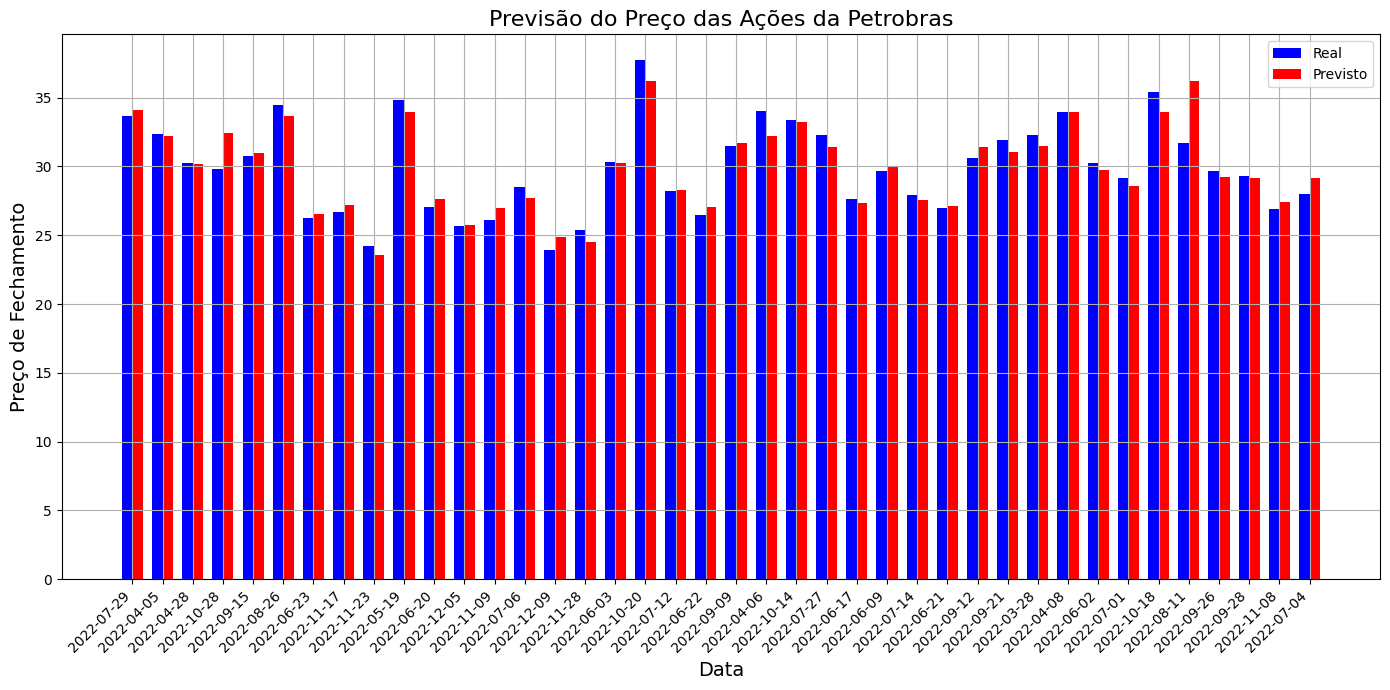

In [2]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Coleta de Dados
print("Coletando dados históricos...")
dados = yf.download('PETR4.SA', start='2022-01-01', end='2023-01-01')

# Tratamento de Dados
print("Tratando dados...")
dados['MMS_20'] = dados['Close'].rolling(window=20).mean()
dados['MMS_50'] = dados['Close'].rolling(window=50).mean()
dados = dados.dropna()

# Análise Exploratória
print("Analisando dados...")
print(dados.describe())

# Engenharia de Características
print("Criando características...")
caracteristicas = dados[['Close', 'MMS_20', 'MMS_50']]
alvo = dados['Close'].shift(-1).dropna()
caracteristicas = caracteristicas.iloc[:-1]

# Divisão dos Dados
print("Dividindo dados em treino e teste...")
X_treino, X_teste, y_treino, y_teste = train_test_split(caracteristicas, alvo, test_size=0.2, random_state=42)

# Construção do Modelo
print("Treinando modelo...")
modelo = LinearRegression()
modelo.fit(X_treino, y_treino)

# Avaliação Inicial
print("Avaliando modelo inicial...")
y_predito = modelo.predict(X_teste)
mse = mean_squared_error(y_teste, y_predito)
r2 = r2_score(y_teste, y_predito)
print(f'MSE inicial: {mse}')
print(f'R2 inicial: {r2}')

# Análise de Sentimentos
print("Analisando sentimentos...")
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Exemplo de análise de sentimentos em português
texto = "O preço das ações da Petrobras deve subir após o anúncio de novos contratos."
sentimento_scores = sid.polarity_scores(texto)
print(f'Análise de Sentimento Exemplo: {sentimento_scores}')

# Dados de Notícias Financeiras (exemplo)
dados_noticias = pd.DataFrame({
    'Data': ['2022-01-01', '2022-01-02'],
    'Notícia': ["A Petrobras assinou novos contratos de exploração.",
                "Analistas preveem queda nas ações da Petrobras."]
})

# Função para calcular o sentimento de cada notícia
def obter_sentimento(noticia):
    return sid.polarity_scores(noticia)['compound']

# Aplicar análise de sentimentos
print("Aplicando análise de sentimentos nas notícias...")
dados_noticias['Sentimento'] = dados_noticias['Notícia'].apply(obter_sentimento)

# Converter a coluna 'Data' para datetime
dados_noticias['Data'] = pd.to_datetime(dados_noticias['Data'])

# Agregar Sentimento Diário
sentimento_diario = dados_noticias.groupby('Data')['Sentimento'].mean().reset_index()

# Integrar Sentimento Diário ao Dataset Principal
print("Integrando sentimentos ao dataset principal...")
dados = dados.reset_index()
dados = dados.rename(columns={'Date': 'Data'})
sentimento_diario = sentimento_diario.rename(columns={'Data': 'Data'})
dados = dados.merge(sentimento_diario, on='Data', how='left').fillna(0)
dados = dados.set_index('Data')

# Atualizar Características com Sentimento
caracteristicas = dados[['Close', 'MMS_20', 'MMS_50', 'Sentimento']]
alvo = dados['Close'].shift(-1).dropna()
caracteristicas = caracteristicas.iloc[:-1]

# Divisão dos Dados (com Sentimento)
X_treino, X_teste, y_treino, y_teste = train_test_split(caracteristicas, alvo, test_size=0.2, random_state=42)

# Treinamento do Modelo Atualizado
print("Treinando modelo atualizado...")
modelo = LinearRegression()
modelo.fit(X_treino, y_treino)

# Avaliação Atualizada
print("Avaliando modelo atualizado...")
y_predito = modelo.predict(X_teste)
mse = mean_squared_error(y_teste, y_predito)
r2 = r2_score(y_teste, y_predito)

print(f'MSE atualizado: {mse}')
print(f'R2 atualizado: {r2}')

# Visualização dos Resultados com Amostragem
plt.figure(figsize=(14, 7))

# Gráfico de barras lado a lado dos valores reais e previstos
largura_barra = 0.35
indices = range(len(y_teste))
plt.bar(indices, y_teste, color='blue', width=largura_barra, label='Real')
plt.bar([i + largura_barra for i in indices], y_predito, color='red', width=largura_barra, label='Previsto')

# Adicionar título e rótulos dos eixos
data_labels = X_teste.index.strftime('%Y-%m-%d')
plt.title('Previsão do Preço das Ações da Petrobras', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Preço de Fechamento', fontsize=14)

# Adicionar rótulos de data para cada barra
plt.xticks([i + largura_barra/2 for i in indices], data_labels, rotation=45, ha='right')

# Adicionar legenda
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


**LEGENDA DA TABELA APRESENTADA**

**Open:** Preço de abertura da ação para cada dia de negociação.

**High:** Maior preço alcançado pela ação durante cada dia de negociação.

**Low:** Menor preço alcançado pela ação durante cada dia de negociação.

**Close:** Preço de fechamento da ação para cada dia de negociação.

**Adj Close:** Preço de fechamento ajustado, levando em consideração eventos como dividendos, splits, etc.

**Volume:** Número de ações negociadas em cada dia.

**MMS_20:** Média Móvel Simples (MMS) de 20 dias dos preços de fechamento.

**MMS_50:** Média Móvel Simples (MMS) de 50 dias dos preços de fechamento.

**ESTATÍSTICAS DESCRITIVAS**

**count:** Número de observações (dias) nos dados, que é 201.

**mean:** Média (valor médio) dos preços ou volumes durante o período.

**std:** Desvio padrão, que mede a dispersão dos preços ou volumes em relação à média.

**min:** Valor mínimo observado durante o período.

**25%:** Primeiro quartil (25% dos valores são menores ou iguais a este valor).

**50% (mediana):** Valor central que divide os dados em duas metades iguais.

**75%:** Terceiro quartil (75% dos valores são menores ou iguais a este valor).

**max:** Valor máximo observado durante o período.